# 開啓這個 Colab Notebook 之後

1. 請選擇 Save a Copy to Drive，將這個 Notebook 複製到你的 Google Drive 内

![alt text](https://drive.google.com/uc?export=download&id=1Lm7c12TZfS509ayfUO8lyacKCYD_C5hy)

接下來我們來安裝 gspread，一個 Python 與 Google Sheet 的串接套件：




In [0]:
!pip install --upgrade --quiet gspread
!pip install gspread-dataframe

In [0]:
# 開啓 google 驗證，允許 colab 對 Google Drive 内的文件進行操作
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

In [0]:
# 建立一個 google client
gc = gspread.authorize(GoogleCredentials.get_application_default())
gc

In [0]:
# 打開名爲 "Lesson 1.2：gspread dataframe" 的 google sheet
gsh = gc.open("Copy of Py x Google Sheet：gspread dataframe 練習")
gsh

<Spreadsheet 'Copy of Py x Google Sheet：gspread dataframe 練習' id:1sE70NWkMQGDhdA5LQB8KvOHQ15bgttXgmbPYP9RhAY8>

In [0]:
# 選擇名爲 S&P 500 的工作表
sh = gsh.worksheet("S&P500")
sh

<Worksheet 'S&P500' id:1893657513>

## worksheet.col_values(column 值)

截取試算表上一整欄的資料

```python
# 會將從左邊數起的第一欄資料以 list 的形式回傳
sh.col_values(1)
```

In [0]:
len(sh.col_values(1))

253

## 偵測試算表上有幾個 row

不幸的是，gspread 沒有類似 `.end()` 的功能

我們可以透過計算 `.col_values()` 回傳的串列資料筆數來計算

```python
# 偵測第一欄的資料筆數
max_row = len(sh.col_values(1))
max_row
# 253
```

In [0]:
# 偵測第一欄的資料筆數
max_row = len(sh.col_values(1))
max_row

253

In [0]:
len(sh.row_values(1))

7

## 偵測試算表上有幾個 column

同上面的邏輯，若我們需要偵測試算表上有幾個 column 時，可以先用 `.row_values()` 得知一個 row 的資料，間接得出有幾個 column：

```python
# 偵測第一欄的資料筆數
max_col = len(sh.row_values(1))
max_col
# 8
```

In [0]:
# 偵測第一行的資料筆數
max_col = len(sh.row_values(1))
max_col

8

## 計算每日報酬率

從 F 欄截取調整後收盤價，計算出每日報酬率，將結果寫入 H 欄

*爲了效能考量，我們從第 2 個 row 計算至第 30 個 row 即可

In [0]:
for i in range(3, 31):
    print(sh.acell(f"F{i}").value)

2713.22
2736.61
2759.82
2784.17
2793.84
2774.02
2798.29
2801.31
2798.43
2809.55
2815.62
2804.49
2801.83
2806.98
2820.4
2846.07
2837.44
2818.82
2802.6
2816.29
2813.36
2827.22
2840.35
2850.4
2858.45
2857.7
2853.58
2833.28


In [0]:
float(sh.acell("F3").value) - float(sh.acell("F2").value)

-13.490000000000236

In [0]:
# 注意資料被讀出來時，都會被解讀成 str (字串)
type(today)

str

In [0]:
for i in range(3, 31):
    today = float(sh.acell(f"F{i}").value)
    yesterday = float(sh.acell(f"F{i-1}").value)
    print(today)
    print(yesterday)
    daily_return = (today - yesterday) * 100 / yesterday
    print(daily_return)
    # 最後將結果寫回試算表
    sh.update_acell(f"H{i}", daily_return)

2713.22
2726.71
-0.4947354137403771
2736.61
2713.22
0.8620753200993775
2759.82
2736.61
0.8481296202235625
2784.17
2759.82
0.8823039183714847
2793.84
2784.17
0.34732074550045694
2774.02
2793.84
-0.7094178621538872
2798.29
2774.02
0.874903569548885
2801.31
2798.29
0.1079230530073717
2798.43
2801.31
-0.10280904291207003
2809.55
2798.43
0.39736566574830695
2815.62
2809.55
0.2160488334430677
2804.49
2815.62
-0.39529481961344604
2801.83
2804.49
-0.09484790461010219
2806.98
2801.83
0.1838084394841975
2820.4
2806.98
0.4780938945058416
2846.07
2820.4
0.9101545880017045
2837.44
2846.07
-0.30322514906520603
2818.82
2837.44
-0.6562253298748129
2802.6
2818.82
-0.5754180827438522
2816.29
2802.6
0.48847498751159835
2813.36
2816.29
-0.10403758135702773
2827.22
2813.36
0.4926493587738388
2840.35
2827.22
0.4644138057880218
2850.4
2840.35
0.35382963367191306
2858.45
2850.4
0.28241650294694526
2857.7
2858.45
-0.026237996116776578
2853.58
2857.7
-0.14417188648213217
2833.28
2853.58
-0.711387099713333


## 小結

可以發現，今天在透過程式操作 Google 試算表時，**由於網路的延遲，大量的讀取與寫入會導致程式的效能變差...**

因此，我們勢必需要一些方法**幫程式加速**，而加速最快的做法，就是**減少讀取與寫入的次數。**

因此，我們會將需要計算的資料一次性的從試算表讀入 Python，計算出結果之後，再一次性的將結果寫入試算表，這樣讀取試算表的次數就會從 2 * n 次減少至 2 次。

要一次性的讀取、存入、並且處理大量的資料，我們可以將之前學會的 `Pandas DataFrame` 拿出來使用。

## gspread 與 DataFrame

接下來我們會使用 `gspread-dataframe` 套件

gspread-dataframe 官方文件：[連結](https://pythonhosted.org/gspread-dataframe/#)

In [0]:
# 引入 pandas 以及 gspread_dataframe 套件
import pandas as pd
import gspread_dataframe as gsdf

## 將工作表内的資料讀入一個 Dataframe

我們可以使用 `get_as_dataframe()` 這個方法：

```python
df = gsdf.get_as_dataframe(
    試算表物件, 
    usecols=需要的欄位數字)
```

注意若要截取多欄的資料，好比 B、C、與 D 欄，就需要以串列的形式指定欄位的值： 
```python
usecols=[2,3,4]
``` 

In [0]:
gsdf.get_as_dataframe(
    sh, 
    usecols=[0,1,2,3,4,5,6] )

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018/7/2,2704.95,2727.26,2698.95,2726.71,2726.71,3.070000e+09
1,2018/7/3,2733.27,2736.58,2711.16,2713.22,2713.22,1.910000e+09
2,2018/7/5,2724.19,2737.83,2716.02,2736.61,2736.61,2.950000e+09
3,2018/7/6,2737.68,2764.41,2733.52,2759.82,2759.82,2.550000e+09
4,2018/7/9,2775.62,2784.65,2770.73,2784.17,2784.17,3.050000e+09
...,...,...,...,...,...,...,...
994,NaN,NaN,NaN,NaN,NaN,NaN,NaN
995,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
# 將工作表内的資料讀入一個 Dataframe
df = gsdf.get_as_dataframe(sh, usecols=list(range(max_col)), parse_dates=True)
df

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return
0,2018/7/2,2704.95,2727.26,2698.95,2726.71,2726.71,3.070000e+09,NaN
1,2018/7/3,2733.27,2736.58,2711.16,2713.22,2713.22,1.910000e+09,-0.494735
2,2018/7/5,2724.19,2737.83,2716.02,2736.61,2736.61,2.950000e+09,0.862075
3,2018/7/6,2737.68,2764.41,2733.52,2759.82,2759.82,2.550000e+09,0.848130
4,2018/7/9,2775.62,2784.65,2770.73,2784.17,2784.17,3.050000e+09,0.882304
...,...,...,...,...,...,...,...,...
994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
df

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return
0,2018/7/2,2704.95,2727.26,2698.95,2726.71,2726.71,3.070000e+09,NaN
1,2018/7/3,2733.27,2736.58,2711.16,2713.22,2713.22,1.910000e+09,-0.494735
2,2018/7/5,2724.19,2737.83,2716.02,2736.61,2736.61,2.950000e+09,0.862075
3,2018/7/6,2737.68,2764.41,2733.52,2759.82,2759.82,2.550000e+09,0.848130
4,2018/7/9,2775.62,2784.65,2770.73,2784.17,2784.17,3.050000e+09,0.882304
...,...,...,...,...,...,...,...,...
994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 多餘的空白資料

另外一件很不幸的事，就是 `get_as_dataframe()` 方法會讀取到第 999 row (Google 試算表預設的限制)

這些沒有值的儲存格，内容也會以空字串的形式被讀入 `DataFrame`

這些多出來的空值被稱爲 Trailing Spaces (尾隨的的空白)

In [0]:
# 利用我們剛才偵測到的最後一個 row，將工作表内有值的資料截取出來
df = df.iloc[:max_row-1]
df

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return
0,2018/7/2,2704.95,2727.26,2698.95,2726.71,2726.71,3.070000e+09,NaN
1,2018/7/3,2733.27,2736.58,2711.16,2713.22,2713.22,1.910000e+09,-0.494735
2,2018/7/5,2724.19,2737.83,2716.02,2736.61,2736.61,2.950000e+09,0.862075
3,2018/7/6,2737.68,2764.41,2733.52,2759.82,2759.82,2.550000e+09,0.848130
4,2018/7/9,2775.62,2784.65,2770.73,2784.17,2784.17,3.050000e+09,0.882304
...,...,...,...,...,...,...,...,...
247,2019/6/26,2926.07,2932.59,2912.99,2913.78,2913.78,3.480000e+09,NaN
248,2019/6/27,2919.66,2929.30,2918.57,2924.92,2924.92,3.120000e+09,NaN
249,2019/6/28,2932.94,2943.98,2929.05,2941.76,2941.76,5.420000e+09,NaN
250,2019/7/1,2971.41,2977.93,2952.22,2964.33,2964.33,3.510000e+09,NaN


In [0]:
# 重新設定索引
df = df.set_index("Date")
df

,Open,High,Low,Close,Adj Close,Volume,Daily Return
Date,,,,,,,
2018/7/2,2704.95,2727.26,2698.95,2726.71,2726.71,3.070000e+09,NaN
2018/7/3,2733.27,2736.58,2711.16,2713.22,2713.22,1.910000e+09,-0.494735
2018/7/5,2724.19,2737.83,2716.02,2736.61,2736.61,2.950000e+09,0.862075
2018/7/6,2737.68,2764.41,2733.52,2759.82,2759.82,2.550000e+09,0.848130
2018/7/9,2775.62,2784.65,2770.73,2784.17,2784.17,3.050000e+09,0.882304
...,...,...,...,...,...,...,...
2019/6/26,2926.07,2932.59,2912.99,2913.78,2913.78,3.480000e+09,NaN
2019/6/27,2919.66,2929.30,2918.57,2924.92,2924.92,3.120000e+09,NaN
2019/6/28,2932.94,2943.98,2929.05,2941.76,2941.76,5.420000e+09,NaN


In [0]:
df.shape

(252, 6)

Text(0.5, 1.0, 'S&P 500 Closing Prices')

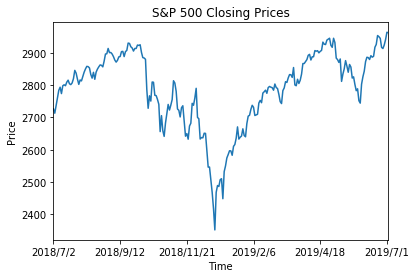

In [0]:
# 利用 Dataframe 畫出走勢圖
plt = df["Adj Close"].plot()
plt.set_xlabel("Time")
plt.set_ylabel("Price")
plt.set_title("S&P 500 Closing Prices")

In [0]:
# 計算出報酬率
df["Adj Close"].pct_change(1) * 100

Date
2018/7/2          NaN
2018/7/3    -0.494735
2018/7/5     0.862075
2018/7/6     0.848130
2018/7/9     0.882304
               ...   
2019/6/26   -0.123398
2019/6/27    0.382321
2019/6/28    0.575742
2019/7/1     0.767228
2019/7/2    -0.059710
Name: Adj Close, Length: 252, dtype: float64

In [0]:
# 將計算的報酬率寫入原本的 Dataframe
df["daily return"] = df["Adj Close"].pct_change(1) * 100
df

,Open,High,Low,Close,Adj Close,Volume,Daily Return,daily return
Date,,,,,,,,
2018/7/2,2704.95,2727.26,2698.95,2726.71,2726.71,3.070000e+09,NaN,NaN
2018/7/3,2733.27,2736.58,2711.16,2713.22,2713.22,1.910000e+09,-0.494735,-0.494735
2018/7/5,2724.19,2737.83,2716.02,2736.61,2736.61,2.950000e+09,0.862075,0.862075
2018/7/6,2737.68,2764.41,2733.52,2759.82,2759.82,2.550000e+09,0.848130,0.848130
2018/7/9,2775.62,2784.65,2770.73,2784.17,2784.17,3.050000e+09,0.882304,0.882304
...,...,...,...,...,...,...,...,...
2019/6/26,2926.07,2932.59,2912.99,2913.78,2913.78,3.480000e+09,NaN,-0.123398
2019/6/27,2919.66,2929.30,2918.57,2924.92,2924.92,3.120000e+09,NaN,0.382321
2019/6/28,2932.94,2943.98,2929.05,2941.76,2941.76,5.420000e+09,NaN,0.575742


In [0]:
# 計算三日移動平均
df["sma_3d"] = df["Adj Close"].rolling(3).mean()
df.fillna(0)
df

,Open,High,Low,Close,Adj Close,Volume,Daily Return,daily return,sma_3d
Date,,,,,,,,,
2018/7/2,2704.95,2727.26,2698.95,2726.71,2726.71,3.070000e+09,NaN,NaN,NaN
2018/7/3,2733.27,2736.58,2711.16,2713.22,2713.22,1.910000e+09,-0.494735,-0.494735,NaN
2018/7/5,2724.19,2737.83,2716.02,2736.61,2736.61,2.950000e+09,0.862075,0.862075,2725.513333
2018/7/6,2737.68,2764.41,2733.52,2759.82,2759.82,2.550000e+09,0.848130,0.848130,2736.550000
2018/7/9,2775.62,2784.65,2770.73,2784.17,2784.17,3.050000e+09,0.882304,0.882304,2760.200000
...,...,...,...,...,...,...,...,...,...
2019/6/26,2926.07,2932.59,2912.99,2913.78,2913.78,3.480000e+09,NaN,-0.123398,2925.503333
2019/6/27,2919.66,2929.30,2918.57,2924.92,2924.92,3.120000e+09,NaN,0.382321,2918.693333
2019/6/28,2932.94,2943.98,2929.05,2941.76,2941.76,5.420000e+09,NaN,0.575742,2926.820000


In [0]:
# 過濾所有上漲的天數
df2 = df[df["daily return"] > 0]
df2

,Open,High,Low,Close,Adj Close,Volume,Daily Return,daily return,sma_3d
Date,,,,,,,,,
2018/7/5,2724.19,2737.83,2716.02,2736.61,2736.61,2.950000e+09,0.862075,0.862075,2725.513333
2018/7/6,2737.68,2764.41,2733.52,2759.82,2759.82,2.550000e+09,0.848130,0.848130,2736.550000
2018/7/9,2775.62,2784.65,2770.73,2784.17,2784.17,3.050000e+09,0.882304,0.882304,2760.200000
2018/7/10,2788.56,2795.58,2786.24,2793.84,2793.84,3.060000e+09,0.347321,0.347321,2779.276667
2018/7/12,2783.14,2799.22,2781.53,2798.29,2798.29,2.820000e+09,0.874904,0.874904,2788.716667
...,...,...,...,...,...,...,...,...,...
2019/6/19,2920.55,2931.74,2911.43,2926.46,2926.46,3.290000e+09,NaN,0.298518,2911.293333
2019/6/20,2949.60,2958.06,2931.50,2954.18,2954.18,3.910000e+09,NaN,0.947220,2932.796667
2019/6/27,2919.66,2929.30,2918.57,2924.92,2924.92,3.120000e+09,NaN,0.382321,2918.693333


In [0]:
df2.shape

(134, 9)

## 新增試算表

我們可以使用 `worksheet.add_worksheet()` 方法

```python
worksheet.add_worksheet(試算表抬頭, 試算表高度, 試算表寬度)
```

In [0]:
# 建立新的工作表，設定新工作表的大小
sh2 = gsh.add_worksheet("filtered S&P 500", df2.shape[0], df2.shape[1])

## 寫入 DataFrame

可以使用 `set_with_dataframe` 方法：

```python
gsdf.set_with_dataframe(
    工作表物件, 
    DataFrame, 
    row=欲寫入範圍左上角 row 值, 
    col=欲寫入範圍左上角 column 值, 
    include_index=True, # include_index 代表是否將 DataFrame 的索引值（最左邊一欄）也匯出
    include_column_header=True, # 是否包含表頭
    resize=True # 會自動調整 Sheet 大小以適應 DataFrame)
```

In [0]:
# 將 Dataframe 寫入工作表
gsdf.set_with_dataframe(
    sh2, 
    df2, 
    row=1, 
    col=1, 
    include_index=True, 
    #include_column_header=True, 
    resize=True)

*筆者碎碎念：由此我們也可以發現，Google 的產品與服務，從一般使用者的角度來看，並不算難用，但是從開發者的角度來看，這些套件其實並不好用（有可能是 Google 假設他們的開發者都是天才，苦笑...）

## 官方文件

gspread-dataframe 官方文件：[連結](https://pythonhosted.org/gspread-dataframe/#)
